In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dataset_number = 3 #thedataset
test_type = 'label' #label ar attack_type

In [5]:
#read file
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)
df.shape

(144500, 25)

In [6]:
#tab label and attack_type
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

In [7]:
#we check if one of the columns contian script
def tag_contain_log4j(row):
    check_colum = ['request.headers.Accept-Encoding',
 'request.headers.Sec-Fetch-Dest',
 'request.headers.Sec-Fetch-Site',
 'request.headers.Set-Cookie']
    for colum in check_colum:
        if isinstance(row[colum], str):
            if '${' in row[colum] and '}' in row[colum]:
                return 1
    return 0

df['log4j_tag'] = df.apply(lambda row: tag_contain_log4j(row), axis=1)

In [8]:
#we chack that one of the columns not contain sql injection // request url
def tag_contain_si(row):
    if '%20' in row['request.url']:
        return 1
    return 0

df['si_tag'] = df.apply(lambda row: tag_contain_si(row), axis=1)

In [9]:
#we chack that one of the columns not contain Directory Traversal // request url
def tag_contain_dt(row):
    check_colum = ['request.url','request.headers.Set-Cookie']
    for colum in check_colum:
        if isinstance(row[colum], str):
            if '/..' in row['request.url']:
                return 1
    return 0

df['dt_tag'] = df.apply(lambda row: tag_contain_dt(row), axis=1)

In [10]:
#we chack that one of the columns not contain xss // request url
def tag_contain_xss(row):
    check_colum = ['request.url']
    for colum in check_colum:
        if isinstance(row[colum], str):
            if '/forum' in row[colum]:
                return 1
    return 0

df['xss_tag'] = df.apply(lambda row: tag_contain_xss(row), axis=1)

In [11]:
#drop attack tag
df.drop('request.Attack_Tag', axis=1, inplace=True)

In [12]:
# fill none
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')

In [13]:
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                 'request.method',
                 'request.headers.Sec-Fetch-Site',
                 'response.status_code',
                  'response.headers.Location',
                  'request.headers.Content-Length'
                ]


COMPLEX_HEADERS = [
                    'request.headers.Set-Cookie',
                    'request.url',
                    'response.body',
                    'response.headers.Content-Length',
                    'request.headers.Cookie'
                    ]


COLUMNS_TO_REMOVE = [ 
                    'request.headers.User-Agent',
                    'request.headers.Sec-Fetch-Dest',
                    'response.headers.Set-Cookie',
                    'request.headers.Host',
                    'request.headers.Accept',
                    'request.headers.Connection',
                    'request.headers.Accept-Language',
                    'request.headers.Sec-Fetch-Mode',
                    'request.headers.Sec-Fetch-User',
                    'request.headers.Date',
                    'request.body',
                    'response.status',
                    'response.headers.Content-Type'
                    ]

In [14]:
def vectorize_df(df):
    # scaling acording to mean ans std
    le = LabelEncoder()
    
    h_vec = HashingVectorizer(n_features=4)

#     Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        # change the text to groups
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS:
        print(column)
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()


request.headers.Set-Cookie
request.url
response.body
response.headers.Content-Length
request.headers.Cookie


,request.headers.Accept-Encoding,request.headers.Sec-Fetch-Site,request.headers.Set-Cookie,request.method,request.url,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,attack_type,label,log4j_tag,si_tag,dt_tag,xss_tag
0,1,1,-0.898027,0,0.927173,0.0,0,-1.000000,14,2,-1.0,RCE,Malware,0,0,0,0
1,1,1,-0.777482,0,0.707107,-1.0,0,-1.000000,14,2,-1.0,Benign,Benign,0,0,0,0
2,1,1,-0.811107,0,0.707107,0.0,0,0.377964,14,2,-1.0,Benign,Benign,0,0,0,0
3,1,1,-0.635001,0,0.000000,-1.0,0,-0.255551,14,2,-1.0,Benign,Benign,0,0,0,0
4,1,1,-0.358569,0,0.316228,0.0,5,0.000000,14,2,-1.0,Benign,Benign,0,0,0,0


In [15]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Accept-Encoding  144500 non-null  int64  
 1   request.headers.Sec-Fetch-Site   144500 non-null  int64  
 2   request.headers.Set-Cookie       144500 non-null  float64
 3   request.method                   144500 non-null  int64  
 4   request.url                      144500 non-null  float64
 5   response.headers.Content-Length  144500 non-null  float64
 6   response.status_code             144500 non-null  int64  
 7   response.body                    144500 non-null  float64
 8   request.headers.Content-Length   144500 non-null  int64  
 9   response.headers.Location        144500 non-null  int64  
 10  request.headers.Cookie           144500 non-null  float64
 11  attack_type                      144500 non-null  object 
 12  la

In [16]:
features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(len(features_list))

15


In [17]:
# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(115600, 15) (115600,)
(28900, 15) (28900,)


Counter({'Malware': 16080, 'Benign': 128420})

In [18]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=170)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 102736), ('Malware', 12864)]


              precision    recall  f1-score   support

      Benign    1.00000   1.00000   1.00000     25684
     Malware    1.00000   1.00000   1.00000      3216

    accuracy                        1.00000     28900
   macro avg    1.00000   1.00000   1.00000     28900
weighted avg    1.00000   1.00000   1.00000     28900



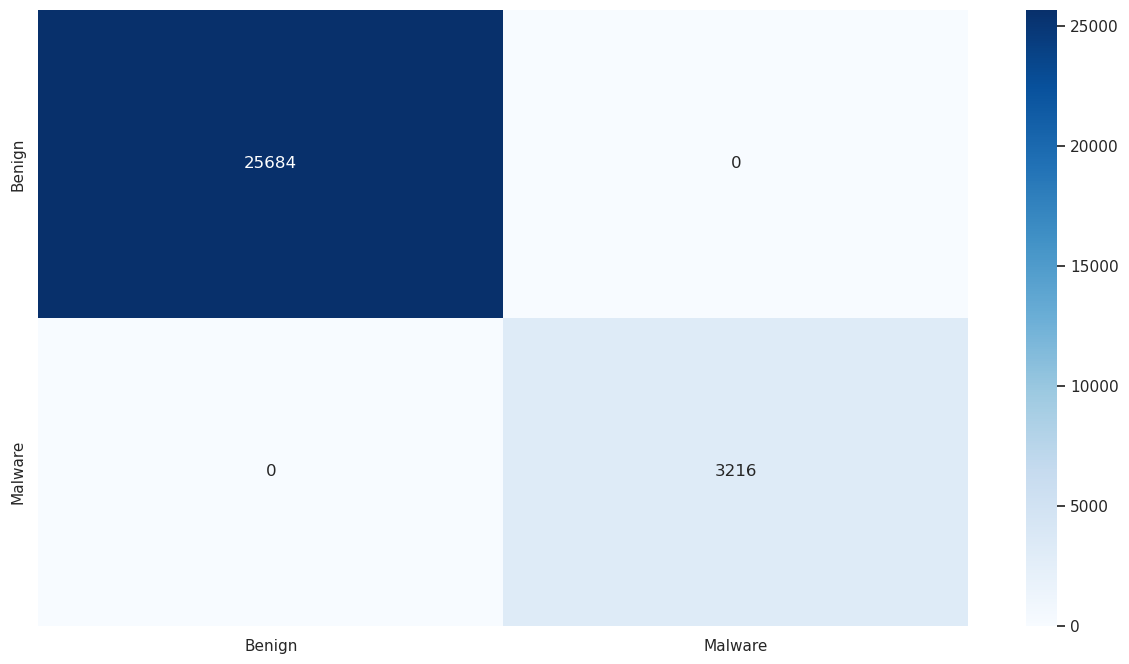

In [19]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

In [20]:


# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)



In [21]:
for column in test_df.columns[test_df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
    

In [22]:
#we check if one of the columns contian script
test_df['log4j_tag'] = test_df.apply(lambda row: tag_contain_log4j(row), axis=1)

#we chack that one of the columns not contain sql injection // request url
test_df['si_tag'] = test_df.apply(lambda row: tag_contain_si(row), axis=1)

#we chack that one of the columns not contain Directory Traversal // request url
test_df['dt_tag'] = test_df.apply(lambda row: tag_contain_dt(row), axis=1)

#we chack that one of the columns not contain xss // request url
test_df['xss_tag'] = test_df.apply(lambda row: tag_contain_xss(row), axis=1)

In [23]:
# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)


request.headers.Set-Cookie
request.url
response.body
response.headers.Content-Length
request.headers.Cookie


In [24]:
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')